---
title: Timor Leste Model Rollout Part 1 (Compute Per-country Populated Grids) 
format:
  html:
    code-fold: false
---

### Import packages

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../")
from povertymapping.geoboundaries import get_geoboundaries
from povertymapping.hdx import get_hdx_file
from geowrangler.grids import BingTileGridGenerator
import geowrangler.spatialjoin_highest_intersection as sjhi
import geowrangler.raster_zonal_stats as rzs
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio as rio


### Set global parameters


In [7]:
REGION = 'timor-leste'
ADMIN_LVL = 'ADM2'
QUADKEY_LVL = 14

### Get admin areas 

In [8]:
%%time
admin_area_file = get_geoboundaries(REGION, adm=ADMIN_LVL); 
admin_area_file

CPU times: user 6.47 ms, sys: 8.05 ms, total: 14.5 ms
Wall time: 15 ms


Path('/home/butchtm/.cache/geowrangler/geoboundaries/TLS_ADM2.geojson')

In [9]:
%%time
admin_gdf = gpd.read_file(admin_area_file)

CPU times: user 425 ms, sys: 8.29 ms, total: 434 ms
Wall time: 463 ms


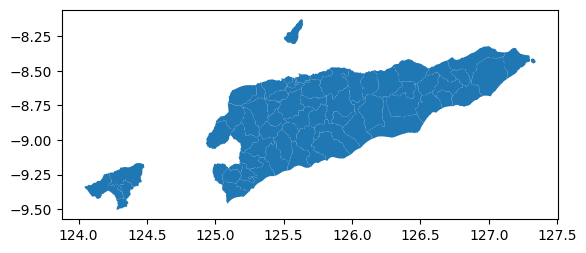

In [10]:
# tl_admin_gdf.explore()
admin_gdf.plot();

In [11]:
admin_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   shapeName   65 non-null     object  
 1   shapeISO    65 non-null     object  
 2   shapeID     65 non-null     object  
 3   shapeGroup  65 non-null     object  
 4   shapeType   65 non-null     object  
 5   geometry    65 non-null     geometry
dtypes: geometry(1), object(5)
memory usage: 3.2+ KB


### Generate Bing Tile Grids

In [12]:
grid_gen = BingTileGridGenerator(QUADKEY_LVL)

In [16]:
%%time
admin_grids_gdf = grid_gen.generate_grid(admin_gdf)

CPU times: user 8.86 s, sys: 7.9 ms, total: 8.87 s
Wall time: 8.88 s


### Map admin areas to grid

In [17]:
%%time
# use a metric crs (e.g. epsg:3857) for computing overlaps
admin_grids_gdf = sjhi.get_highest_intersection(admin_grids_gdf, admin_gdf,'epsg:3857')

CPU times: user 833 ms, sys: 533 µs, total: 834 ms
Wall time: 842 ms


<AxesSubplot: >

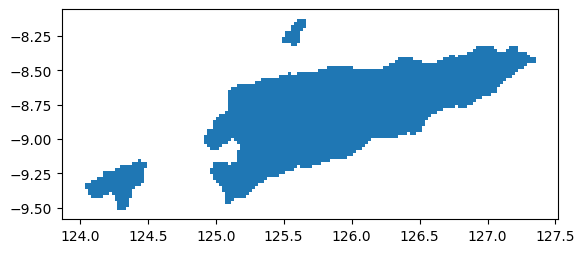

In [18]:
# admin_grids_gdf.explore()
admin_grids_gdf.plot()

### Get Population Density dataset (from Humanitarian Data Exchange)

In [19]:
%%time
hdx_pop_file = get_hdx_file(REGION)
hdx_pop_file

CPU times: user 60.6 ms, sys: 1.71 ms, total: 62.3 ms
Wall time: 1.32 s


Path('/home/butchtm/.cache/geowrangler/hdx/tls_general_2020.tif')

In [22]:
%%time
with rio.open(hdx_pop_file) as src:
    data = src.read(1)
    profile = src.profile
    

CPU times: user 114 ms, sys: 1.16 s, total: 1.27 s
Wall time: 2.26 s


In [23]:
print(profile)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': nan, 'width': 14400, 'height': 7200, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777780012, 0.0, 123.99986111135561,
       0.0, -0.0002777777777780012, -7.999861111174923), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}


### Compute population zonal statistics for Grid AOIs

In [24]:
%%time
admin_grids_gdf = rzs.create_raster_zonal_stats(admin_grids_gdf, hdx_pop_file,
                                             aggregation=dict(column='population',
                                                               output='pop_count',
                                                               func='sum'),
                                             extra_args=dict(
                                                 nodata=np.nan))

CPU times: user 8.32 s, sys: 10.2 s, total: 18.5 s
Wall time: 18.5 s


### Filter grids with zero pop_count

In [25]:
len(admin_grids_gdf)

2811

In [26]:
len(admin_grids_gdf[admin_grids_gdf['pop_count'] > 0])

2024

In [27]:
admin_grids_gdf = admin_grids_gdf[admin_grids_gdf['pop_count'] > 0]

### Save per country populated grids

In [28]:
%%time
admin_grids_gdf.to_file(f'{REGION}_populated_grids.geojson', driver='GeoJSON')

/home/butchtm/work/povmap/fresh-povmap/env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


CPU times: user 362 ms, sys: 0 ns, total: 362 ms
Wall time: 382 ms


### Explore per country populated grids

<AxesSubplot: >

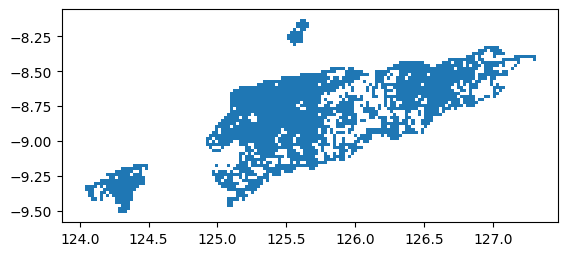

In [29]:
# admin_grids_gdf.explore()
admin_grids_gdf.plot()


In [30]:
admin_grids_gdf.columns

Index(['geometry', 'quadkey', 'shapeName', 'shapeISO', 'shapeID', 'shapeGroup',
       'shapeType', 'pop_count'],
      dtype='object')

In [31]:
admin_grids_gdf.head()

,geometry,quadkey,shapeName,shapeISO,shapeID,shapeGroup,shapeType,pop_count
0,"POLYGON ((124.03564 -9.34067, 124.03564 -9.318...",31011220203121,Nitibe,None,TLS-ADM2-3_0_0-B58,TLS,ADM2,102.251936
1,"POLYGON ((124.03564 -9.36235, 124.03564 -9.340...",31011220203123,Nitibe,None,TLS-ADM2-3_0_0-B58,TLS,ADM2,992.492772
2,"POLYGON ((124.05762 -9.34067, 124.05762 -9.318...",31011220203130,Nitibe,None,TLS-ADM2-3_0_0-B58,TLS,ADM2,118.897600
3,"POLYGON ((124.05762 -9.36235, 124.05762 -9.340...",31011220203132,Nitibe,None,TLS-ADM2-3_0_0-B58,TLS,ADM2,513.637632
4,"POLYGON ((124.05762 -9.38403, 124.05762 -9.362...",31011220203310,Nitibe,None,TLS-ADM2-3_0_0-B58,TLS,ADM2,319.140940
